# Introdução à Ciência de Dados - Trabalho Módulo 1

## Criando um dataset de carros usados coletados a partir da OLX

### Sumário

1. [Objetivo](#Objetivo)
2. [Importações das bibliotecas necessárias e definição de constantes globais](#Importações-da-bibliotecas-necessárias-e-definição-de-constantes-globais)
3. [Extração das urls dos carros de cada página da OLX](#Extração-das-urls-dos-carros-de-cada-página-da-OLX)
4. [Extraindo as informações de cada carro a partir das urls](#Extraindo-as-informações-de-cada-carro-a-partir-das-urls)
    - [Usando um único processo](#Abordagem-Single-Thread)
    - [Usando múltiplos processo (cerca de 10x mais rápido)](#Abordagem-Multithread)
5. [Agrupando as informações de múltiplos CSVs](#Agrupando-as-informações-de-múltiplos-CSVs)
6. [Limpando o dataset](#Limpando-o-dataset)

## Objetivo


Este trabalho propõe-se a criar um dataset de carros usados utilizando informações públicas disponíveis na plataforma da OLX.

## Importações da bibliotecas necessárias e definição de constantes globais

In [24]:
import pandas as pd
import numpy as np
import json
from bs4 import BeautifulSoup
import requests
import os
from tqdm import tqdm
from multiprocessing import Pool
import matplotlib.pyplot as plt

In [2]:
HEADERS = {
        'authority': 'olx.com.br',
        'method': 'GET',
        'scheme': 'https',
        'sec-fetch-mode': 'navigate',
        'sec-fetch-site': 'same-origin',
        'sec-fetch-user': '?1',
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko)'
}

## Extração das urls dos carros de cada página da OLX

### Coleta  dos links

In [3]:
def get_number_pages(base_url):
    response = requests.get(url=base_url, headers=HEADERS)
    soup = BeautifulSoup(response.content, 'lxml')
    results = soup.findAll('span', {'class': 'sc-1mi5vq6-0 eDXljX sc-ifAKCX fhJlIo'})

    ITEMS_PER_PAGE = 50
    n_cars_found = float(results[0].contents[0].split('de ')[-1].split(' ')[0].replace('.', ''))
    
    return min(int(n_cars_found/ITEMS_PER_PAGE), 100)

In [4]:
def collect_links(state):
    base_url = f'https://{state}.olx.com.br/autos-e-pecas/carros-vans-e-utilitarios'
    
    n_pages = get_number_pages(base_url)

    for page in range(n_pages-1):
        
        url = f'{base_url}?o={page+1}'
        response = requests.get(url=url, headers=HEADERS)
        
        soup = BeautifulSoup(response.content, 'lxml')
        items = soup.find_all('li', {'class': 'sc-1fcmfeb-2 juiJqh'})
        
        output_folder = 'links'
        
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        
        for item in items:
            try:
                with open(f'{output_folder}/{state}.txt', 'a') as outfile:
                    link = item.findAll('a')[0]['href']+'\n'
                    outfile.write(link)
            except IndexError:
                continue
        
    return 0                

In [ ]:
links_file = 'links.txt'

states = ['ac', 'al', 'ap', 'am', 'ba', 'ce', 'df', 'es', 'go', 'ma', 'mt', 'mg', 'ms', 'pa', 
          'pb', 'pr', 'pe', 'pi', 'rj', 'rn', 'rs', 'ro', 'rr', 'sc', 'sp', 'se', 'to']

if not os.path.exists(links_file):    
    pool = Pool(10)
    for link in tqdm(pool.imap_unordered(collect_links, states), total=len(states)):
        continue

    pool.terminate()
    pool.join()

 89%|████████▉ | 24/27 [07:41<01:27, 29.01s/it]

### Combinação dos links de todos os estados em um só txt

In [28]:
import glob

if not os.path.exists(links_file):
    files = glob.glob(os.path.join('links', '*.txt'))
    print(files)
    urls = []
    for file in files:
        with open(file, 'r') as infile:
            urls += infile.read()
    
    urls = ''.join(urls)
    
    with open('links.txt', 'w') as outfile:
        outfile.write(urls)

['links/sc.txt', 'links/sp.txt', 'links/es.txt', 'links/mt.txt', 'links/ce.txt', 'links/ro.txt', 'links/ap.txt', 'links/rn.txt', 'links/pb.txt', 'links/am.txt', 'links/rr.txt', 'links/rj.txt', 'links/ac.txt', 'links/se.txt', 'links/ma.txt', 'links/to.txt', 'links/go.txt', 'links/mg.txt', 'links/ba.txt', 'links/rs.txt', 'links/pa.txt', 'links/pr.txt', 'links/pe.txt', 'links/al.txt', 'links/df.txt', 'links/pi.txt', 'links/ms.txt']


## Extraindo as informações de cada carro a partir das urls

In [3]:
def extract_car_info(link):
    response = requests.get(url=link, headers=HEADERS)
    soup = BeautifulSoup(response.content, 'lxml')

    items = soup.find_all('div', {'class': 'sc-hmzhuo eNZSNe sc-jTzLTM iwtnNi'})

    car = {}
    # Caracteristics
    for item in items:
        title = item.find_all('span', {'class': 'sc-ifAKCX dCObfG'})[0].contents[0]
        try:
            value = item.find_all('span', {'class': 'sc-ifAKCX cmFKIN'})[0].contents[0]
        except:
            value = item.find_all('a', {'class': 'sc-57pm5w-0 XtcoW'})[0].contents[0]

        car[title] = value

    locations = soup.find_all('div', {'class': 'sc-hmzhuo sc-1f2ug0x-3 ONRJp sc-jTzLTM iwtnNi'})

    # Location
    for location in locations:
        title = location.find_all('dt', {'class': 'sc-1f2ug0x-0 cLGFbW sc-ifAKCX cmFKIN'})[0].contents[0]
        try:
            value = location.find_all('dd', {'class': 'sc-1f2ug0x-1 ljYeKO sc-ifAKCX kaNiaQ'})[0].contents[0]
        except:
            value = None

        car[title] = value

    try:
        price = soup.find_all('h2', {'class': 'sc-1leoitd-0 cIfjkh sc-ifAKCX cmFKIN'})[0].contents[0]
        price = float(price.split('R$ ')[-1].replace('.', ''))
    except:
        price = None
    
    car['price'] = price
    car['url'] = link.strip()
    
    return car

### Abordagem Single Thread

In [13]:
def proccess_links(file):
    cars = []
    with open(file, 'r') as infile:
        links = infile.readlines()
        
        for link in tqdm(links):
            car = extract_car_info(link)
            cars.append(car)

    df = pd.DataFrame(cars)
    df.to_csv('olx_cars.csv')

In [ ]:
links_file = 'links.txt'
proccess_links(links_file)

### Abordagem Multithread

In [4]:
import sys
sys.setrecursionlimit(50000)

In [5]:
from multiprocessing import Pool

links_file = 'links.txt'

urls = []
with open(links_file, 'r') as infile:
    urls = infile.readlines()
    
output_folder = 'output_csvs'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
pool = Pool(10)
results = []
count = 0

for result in tqdm(pool.imap_unordered(extract_car_info, urls), total=len(urls)):
    if len(results) > 5000:
        df = pd.DataFrame(results)
        df.to_csv(f'{output_folder}/olx_cars_{count}.csv', index=False)
        count += 1
        
        results.clear()
        del df
    
    results.append(result)

df = pd.DataFrame(results)
df.to_csv(f'{output_folder}/olx_cars_{count}.csv', index=False)

pool.terminate()
pool.join()

100%|██████████| 116304/116304 [3:30:24<00:00,  9.21it/s]  


## Agrupando as informações de múltiplos CSVs

In [6]:
import glob

output_folder = 'output_csvs'

csv_files = glob.glob(os.path.join(output_folder, '*.csv'))

df = pd.concat((pd.read_csv(file) for file in csv_files))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116304 entries, 0 to 5000
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Categoria          114984 non-null  object 
 1   Modelo             114984 non-null  object 
 2   Marca              113229 non-null  object 
 3   Tipo de veículo    99019 non-null   object 
 4   Ano                114983 non-null  object 
 5   Quilometragem      114982 non-null  float64
 6   Potência do motor  95463 non-null   object 
 7   Combustível        109877 non-null  object 
 8   Câmbio             110536 non-null  object 
 9   Direção            97241 non-null   object 
 10  Cor                100439 non-null  object 
 11  Portas             107942 non-null  object 
 12  Final de placa     95232 non-null   float64
 13  CEP                114990 non-null  float64
 14  Município          114989 non-null  object 
 15  Bairro             98509 non-null   object 
 16  pric

In [7]:
df.describe()

,Quilometragem,Final de placa,CEP,price,Novo/Usado
count,1.149820e+05,95232.000000,1.149900e+05,1.115450e+05,0.0
mean,8.630783e+08,4.361150,6.118903e+07,6.360686e+04,NaN
std,2.912635e+11,3.008551,2.038487e+07,4.715628e+05,NaN
min,0.000000e+00,0.000000,1.001001e+06,0.000000e+00,NaN
25%,2.600000e+04,2.000000,5.072000e+07,2.600000e+04,NaN
50%,6.500000e+04,4.000000,6.506664e+07,4.480000e+04,NaN
75%,1.090000e+05,7.000000,7.682441e+07,7.249100e+04,NaN
max,9.876448e+13,9.000000,9.998000e+07,8.590000e+07,NaN


### Limpando o dataset

Após ser feita a junção de todos os CSVs, devemos limpar algumas irregularidades que o dataset possui como segue abaixo

In [8]:
df

,Categoria,Modelo,Marca,Tipo de veículo,Ano,Quilometragem,Potência do motor,Combustível,Câmbio,Direção,Cor,Portas,Final de placa,CEP,Município,Bairro,price,url,Tipo,Novo/Usado
0,"Carros, vans e utilitários",FIAT TORO FREEDOM 1.8 16V FLEX AUT.,FIAT,Pick-up,2017,86200.0,1.8,Flex,Automático,Hidráulica,Preto,4 portas,5.0,76964008.0,Cacoal,Princesa Isabel,82500.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,NaN,NaN
1,"Carros, vans e utilitários",VW - VOLKSWAGEN UP! TAKE 1.0 TOTAL FLEX 12V 5P,VW - VOLKSWAGEN,Hatch,2015,100000.0,1.0,Flex,Manual,Hidráulica,Branco,4 portas,7.0,76890000.0,Jaru,NaN,32500.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,NaN,NaN
2,"Carros, vans e utilitários",GM - CHEVROLET PRISMA SED. LT 1.4 8V FLEXPOWER 4P,GM - CHEVROLET,Sedã,2017,64000.0,1.4,Flex,Manual,Elétrica,Preto,4 portas,1.0,76821468.0,Porto Velho,Rio Madeira,52900.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,NaN,NaN
3,"Carros, vans e utilitários",FIAT SIENA ELX 1.0 MPI FIRE/FIRE FLEX 8V 4P,FIAT,Passeio,2007,125869.0,1.0,Flex,Manual,Mecânica,Branco,4 portas,4.0,76812476.0,Porto Velho,Três Marias,14000.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,NaN,NaN
4,"Carros, vans e utilitários",FIAT IDEA ADV.EXT./ADV.EXT. LOC. 1.8 FLEX 5P,FIAT,Hatch,2013,40000.0,1.8,Flex,Automático,Hidráulica,Verde,4 portas,7.0,76890000.0,Jaru,NaN,33000.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,"Carros, vans e utilitários",HYUNDAI HB20 COMF./C.PLUS/C.STYLE 1.0 FLEX 12V,HYUNDAI,Passeio,2018,37000.0,NaN,Flex,Manual,NaN,NaN,4 portas,8.0,66123620.0,Belém,Sacramenta,49900.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...,NaN,NaN
4997,"Carros, vans e utilitários",FIAT TORO FREEDOM 1.8 16V FLEX AUT.,FIAT,Pick-up,2019,43000.0,1.8,Flex,Automático,Elétrica,Branco,4 portas,7.0,66093972.0,Belém,Marco,99990.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...,NaN,NaN
4998,"Carros, vans e utilitários",GM - CHEVROLET PRISMA SED. LT 1.4 8V FLEXPOWER...,GM - CHEVROLET,Sedã,2017,31.0,1.4,Flex,Automático,Elétrica,NaN,4 portas,4.0,66120620.0,Belém,Sacramenta,62900.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...,NaN,NaN
4999,"Carros, vans e utilitários",HYUNDAI HB20 C.STYLE/C.PLUS 1.6 FLEX 16V AUT.,HYUNDAI,Hatch,2015,77.0,1.6,Flex,Automático,Hidráulica,NaN,4 portas,6.0,66120620.0,Belém,Sacramenta,44900.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...,NaN,NaN


Primeiramente, existem linhas com todos os atributos vazios (NaN), essas linhas são referentes a propagandas que são coletadas como links de carros no site da OLX e não apresentam nenhuma dos campos de carro.

In [9]:
# Contanto o número de elementos que serão eliminados
df['Modelo'].isna().sum()

1320

In [10]:
# Eliminar colunas que tem modelo com NaN
df.dropna(subset=['Modelo'], inplace=True)
df

,Categoria,Modelo,Marca,Tipo de veículo,Ano,Quilometragem,Potência do motor,Combustível,Câmbio,Direção,Cor,Portas,Final de placa,CEP,Município,Bairro,price,url,Tipo,Novo/Usado
0,"Carros, vans e utilitários",FIAT TORO FREEDOM 1.8 16V FLEX AUT.,FIAT,Pick-up,2017,86200.0,1.8,Flex,Automático,Hidráulica,Preto,4 portas,5.0,76964008.0,Cacoal,Princesa Isabel,82500.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,NaN,NaN
1,"Carros, vans e utilitários",VW - VOLKSWAGEN UP! TAKE 1.0 TOTAL FLEX 12V 5P,VW - VOLKSWAGEN,Hatch,2015,100000.0,1.0,Flex,Manual,Hidráulica,Branco,4 portas,7.0,76890000.0,Jaru,NaN,32500.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,NaN,NaN
2,"Carros, vans e utilitários",GM - CHEVROLET PRISMA SED. LT 1.4 8V FLEXPOWER 4P,GM - CHEVROLET,Sedã,2017,64000.0,1.4,Flex,Manual,Elétrica,Preto,4 portas,1.0,76821468.0,Porto Velho,Rio Madeira,52900.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,NaN,NaN
3,"Carros, vans e utilitários",FIAT SIENA ELX 1.0 MPI FIRE/FIRE FLEX 8V 4P,FIAT,Passeio,2007,125869.0,1.0,Flex,Manual,Mecânica,Branco,4 portas,4.0,76812476.0,Porto Velho,Três Marias,14000.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,NaN,NaN
4,"Carros, vans e utilitários",FIAT IDEA ADV.EXT./ADV.EXT. LOC. 1.8 FLEX 5P,FIAT,Hatch,2013,40000.0,1.8,Flex,Automático,Hidráulica,Verde,4 portas,7.0,76890000.0,Jaru,NaN,33000.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,"Carros, vans e utilitários",HYUNDAI HB20 COMF./C.PLUS/C.STYLE 1.0 FLEX 12V,HYUNDAI,Passeio,2018,37000.0,NaN,Flex,Manual,NaN,NaN,4 portas,8.0,66123620.0,Belém,Sacramenta,49900.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...,NaN,NaN
4997,"Carros, vans e utilitários",FIAT TORO FREEDOM 1.8 16V FLEX AUT.,FIAT,Pick-up,2019,43000.0,1.8,Flex,Automático,Elétrica,Branco,4 portas,7.0,66093972.0,Belém,Marco,99990.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...,NaN,NaN
4998,"Carros, vans e utilitários",GM - CHEVROLET PRISMA SED. LT 1.4 8V FLEXPOWER...,GM - CHEVROLET,Sedã,2017,31.0,1.4,Flex,Automático,Elétrica,NaN,4 portas,4.0,66120620.0,Belém,Sacramenta,62900.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...,NaN,NaN
4999,"Carros, vans e utilitários",HYUNDAI HB20 C.STYLE/C.PLUS 1.6 FLEX 16V AUT.,HYUNDAI,Hatch,2015,77.0,1.6,Flex,Automático,Hidráulica,NaN,4 portas,6.0,66120620.0,Belém,Sacramenta,44900.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...,NaN,NaN


Na OLX, existem anúncios de carros com o preço de R\\$ 0,00. E carros com valores muito altos e que não condizem com o carro. Para eliminar esses valores incorretos limitaremos o dataset a carros com preços variando de R\\$ 5000,00 a R\\$ 500000,00.

<AxesSubplot:ylabel='Frequency'>

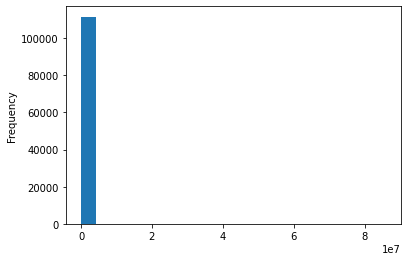

In [11]:
df['price'].plot.hist(bins=20)

In [16]:
df = df[df['price'] >= 5000]
df = df[df['price'] <= 400000]
df

,Categoria,Modelo,Marca,Tipo de veículo,Ano,Quilometragem,Potência do motor,Combustível,Câmbio,Direção,Cor,Portas,Final de placa,CEP,Município,Bairro,price,url,Tipo,Novo/Usado
0,"Carros, vans e utilitários",FIAT TORO FREEDOM 1.8 16V FLEX AUT.,FIAT,Pick-up,2017,86200.0,1.8,Flex,Automático,Hidráulica,Preto,4 portas,5.0,76964008.0,Cacoal,Princesa Isabel,82500.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,NaN,NaN
1,"Carros, vans e utilitários",VW - VOLKSWAGEN UP! TAKE 1.0 TOTAL FLEX 12V 5P,VW - VOLKSWAGEN,Hatch,2015,100000.0,1.0,Flex,Manual,Hidráulica,Branco,4 portas,7.0,76890000.0,Jaru,NaN,32500.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,NaN,NaN
2,"Carros, vans e utilitários",GM - CHEVROLET PRISMA SED. LT 1.4 8V FLEXPOWER 4P,GM - CHEVROLET,Sedã,2017,64000.0,1.4,Flex,Manual,Elétrica,Preto,4 portas,1.0,76821468.0,Porto Velho,Rio Madeira,52900.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,NaN,NaN
3,"Carros, vans e utilitários",FIAT SIENA ELX 1.0 MPI FIRE/FIRE FLEX 8V 4P,FIAT,Passeio,2007,125869.0,1.0,Flex,Manual,Mecânica,Branco,4 portas,4.0,76812476.0,Porto Velho,Três Marias,14000.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,NaN,NaN
4,"Carros, vans e utilitários",FIAT IDEA ADV.EXT./ADV.EXT. LOC. 1.8 FLEX 5P,FIAT,Hatch,2013,40000.0,1.8,Flex,Automático,Hidráulica,Verde,4 portas,7.0,76890000.0,Jaru,NaN,33000.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,"Carros, vans e utilitários",PEUGEOT 207,PEUGEOT,Sedã,2013,65.0,NaN,Flex,Manual,NaN,Branco,4 portas,7.0,67020000.0,Ananindeua,Águas Lindas,24900.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...,NaN,NaN
4996,"Carros, vans e utilitários",HYUNDAI HB20 COMF./C.PLUS/C.STYLE 1.0 FLEX 12V,HYUNDAI,Passeio,2018,37000.0,NaN,Flex,Manual,NaN,NaN,4 portas,8.0,66123620.0,Belém,Sacramenta,49900.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...,NaN,NaN
4997,"Carros, vans e utilitários",FIAT TORO FREEDOM 1.8 16V FLEX AUT.,FIAT,Pick-up,2019,43000.0,1.8,Flex,Automático,Elétrica,Branco,4 portas,7.0,66093972.0,Belém,Marco,99990.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...,NaN,NaN
4998,"Carros, vans e utilitários",GM - CHEVROLET PRISMA SED. LT 1.4 8V FLEXPOWER...,GM - CHEVROLET,Sedã,2017,31.0,1.4,Flex,Automático,Elétrica,NaN,4 portas,4.0,66120620.0,Belém,Sacramenta,62900.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...,NaN,NaN


<AxesSubplot:ylabel='Frequency'>

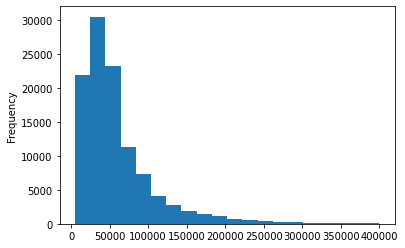

In [17]:
df['price'].plot.hist(bins=20)

Outras colunas que podem ser eliminadas são Tipo e Novo/Usado, visto que 100% dos elementos não possuem essas informações, tornando-as irrelevantes para o dataset. Como pode ser visto logo abaixo:

In [18]:
df['Novo/Usado'].isna().sum(), df['Tipo'].isna().sum()

(107991, 107991)

In [19]:
df.drop(labels=['Novo/Usado', 'Tipo'], axis=1, inplace=True)
df

,Categoria,Modelo,Marca,Tipo de veículo,Ano,Quilometragem,Potência do motor,Combustível,Câmbio,Direção,Cor,Portas,Final de placa,CEP,Município,Bairro,price,url
0,"Carros, vans e utilitários",FIAT TORO FREEDOM 1.8 16V FLEX AUT.,FIAT,Pick-up,2017,86200.0,1.8,Flex,Automático,Hidráulica,Preto,4 portas,5.0,76964008.0,Cacoal,Princesa Isabel,82500.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...
1,"Carros, vans e utilitários",VW - VOLKSWAGEN UP! TAKE 1.0 TOTAL FLEX 12V 5P,VW - VOLKSWAGEN,Hatch,2015,100000.0,1.0,Flex,Manual,Hidráulica,Branco,4 portas,7.0,76890000.0,Jaru,NaN,32500.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...
2,"Carros, vans e utilitários",GM - CHEVROLET PRISMA SED. LT 1.4 8V FLEXPOWER 4P,GM - CHEVROLET,Sedã,2017,64000.0,1.4,Flex,Manual,Elétrica,Preto,4 portas,1.0,76821468.0,Porto Velho,Rio Madeira,52900.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...
3,"Carros, vans e utilitários",FIAT SIENA ELX 1.0 MPI FIRE/FIRE FLEX 8V 4P,FIAT,Passeio,2007,125869.0,1.0,Flex,Manual,Mecânica,Branco,4 portas,4.0,76812476.0,Porto Velho,Três Marias,14000.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...
4,"Carros, vans e utilitários",FIAT IDEA ADV.EXT./ADV.EXT. LOC. 1.8 FLEX 5P,FIAT,Hatch,2013,40000.0,1.8,Flex,Automático,Hidráulica,Verde,4 portas,7.0,76890000.0,Jaru,NaN,33000.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,"Carros, vans e utilitários",PEUGEOT 207,PEUGEOT,Sedã,2013,65.0,NaN,Flex,Manual,NaN,Branco,4 portas,7.0,67020000.0,Ananindeua,Águas Lindas,24900.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...
4996,"Carros, vans e utilitários",HYUNDAI HB20 COMF./C.PLUS/C.STYLE 1.0 FLEX 12V,HYUNDAI,Passeio,2018,37000.0,NaN,Flex,Manual,NaN,NaN,4 portas,8.0,66123620.0,Belém,Sacramenta,49900.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...
4997,"Carros, vans e utilitários",FIAT TORO FREEDOM 1.8 16V FLEX AUT.,FIAT,Pick-up,2019,43000.0,1.8,Flex,Automático,Elétrica,Branco,4 portas,7.0,66093972.0,Belém,Marco,99990.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...
4998,"Carros, vans e utilitários",GM - CHEVROLET PRISMA SED. LT 1.4 8V FLEXPOWER...,GM - CHEVROLET,Sedã,2017,31.0,1.4,Flex,Automático,Elétrica,NaN,4 portas,4.0,66120620.0,Belém,Sacramenta,62900.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...


A próxima limpeza que podemos fazer é tornar a coluna 'Portas' com apenas o número de portas ao invés de repetir o nome portas em todas as vezes.

In [20]:
df['Portas'].replace({'4 portas': 4, '2 portas': 2}, inplace=True)
df

,Categoria,Modelo,Marca,Tipo de veículo,Ano,Quilometragem,Potência do motor,Combustível,Câmbio,Direção,Cor,Portas,Final de placa,CEP,Município,Bairro,price,url
0,"Carros, vans e utilitários",FIAT TORO FREEDOM 1.8 16V FLEX AUT.,FIAT,Pick-up,2017,86200.0,1.8,Flex,Automático,Hidráulica,Preto,4.0,5.0,76964008.0,Cacoal,Princesa Isabel,82500.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...
1,"Carros, vans e utilitários",VW - VOLKSWAGEN UP! TAKE 1.0 TOTAL FLEX 12V 5P,VW - VOLKSWAGEN,Hatch,2015,100000.0,1.0,Flex,Manual,Hidráulica,Branco,4.0,7.0,76890000.0,Jaru,NaN,32500.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...
2,"Carros, vans e utilitários",GM - CHEVROLET PRISMA SED. LT 1.4 8V FLEXPOWER 4P,GM - CHEVROLET,Sedã,2017,64000.0,1.4,Flex,Manual,Elétrica,Preto,4.0,1.0,76821468.0,Porto Velho,Rio Madeira,52900.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...
3,"Carros, vans e utilitários",FIAT SIENA ELX 1.0 MPI FIRE/FIRE FLEX 8V 4P,FIAT,Passeio,2007,125869.0,1.0,Flex,Manual,Mecânica,Branco,4.0,4.0,76812476.0,Porto Velho,Três Marias,14000.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...
4,"Carros, vans e utilitários",FIAT IDEA ADV.EXT./ADV.EXT. LOC. 1.8 FLEX 5P,FIAT,Hatch,2013,40000.0,1.8,Flex,Automático,Hidráulica,Verde,4.0,7.0,76890000.0,Jaru,NaN,33000.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,"Carros, vans e utilitários",PEUGEOT 207,PEUGEOT,Sedã,2013,65.0,NaN,Flex,Manual,NaN,Branco,4.0,7.0,67020000.0,Ananindeua,Águas Lindas,24900.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...
4996,"Carros, vans e utilitários",HYUNDAI HB20 COMF./C.PLUS/C.STYLE 1.0 FLEX 12V,HYUNDAI,Passeio,2018,37000.0,NaN,Flex,Manual,NaN,NaN,4.0,8.0,66123620.0,Belém,Sacramenta,49900.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...
4997,"Carros, vans e utilitários",FIAT TORO FREEDOM 1.8 16V FLEX AUT.,FIAT,Pick-up,2019,43000.0,1.8,Flex,Automático,Elétrica,Branco,4.0,7.0,66093972.0,Belém,Marco,99990.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...
4998,"Carros, vans e utilitários",GM - CHEVROLET PRISMA SED. LT 1.4 8V FLEXPOWER...,GM - CHEVROLET,Sedã,2017,31.0,1.4,Flex,Automático,Elétrica,NaN,4.0,4.0,66120620.0,Belém,Sacramenta,62900.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...


A coluna categoria é outra coluna que pode ser eliminada visto que todos os carros pertencem a mesma categoria como pode ser visto abaixo:

In [21]:
df['Categoria'].unique()

array(['Carros, vans e utilitários'], dtype=object)

In [22]:
df.drop(labels='Categoria', axis=1, inplace=True)
df

,Modelo,Marca,Tipo de veículo,Ano,Quilometragem,Potência do motor,Combustível,Câmbio,Direção,Cor,Portas,Final de placa,CEP,Município,Bairro,price,url
0,FIAT TORO FREEDOM 1.8 16V FLEX AUT.,FIAT,Pick-up,2017,86200.0,1.8,Flex,Automático,Hidráulica,Preto,4.0,5.0,76964008.0,Cacoal,Princesa Isabel,82500.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...
1,VW - VOLKSWAGEN UP! TAKE 1.0 TOTAL FLEX 12V 5P,VW - VOLKSWAGEN,Hatch,2015,100000.0,1.0,Flex,Manual,Hidráulica,Branco,4.0,7.0,76890000.0,Jaru,NaN,32500.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...
2,GM - CHEVROLET PRISMA SED. LT 1.4 8V FLEXPOWER 4P,GM - CHEVROLET,Sedã,2017,64000.0,1.4,Flex,Manual,Elétrica,Preto,4.0,1.0,76821468.0,Porto Velho,Rio Madeira,52900.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...
3,FIAT SIENA ELX 1.0 MPI FIRE/FIRE FLEX 8V 4P,FIAT,Passeio,2007,125869.0,1.0,Flex,Manual,Mecânica,Branco,4.0,4.0,76812476.0,Porto Velho,Três Marias,14000.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...
4,FIAT IDEA ADV.EXT./ADV.EXT. LOC. 1.8 FLEX 5P,FIAT,Hatch,2013,40000.0,1.8,Flex,Automático,Hidráulica,Verde,4.0,7.0,76890000.0,Jaru,NaN,33000.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,PEUGEOT 207,PEUGEOT,Sedã,2013,65.0,NaN,Flex,Manual,NaN,Branco,4.0,7.0,67020000.0,Ananindeua,Águas Lindas,24900.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...
4996,HYUNDAI HB20 COMF./C.PLUS/C.STYLE 1.0 FLEX 12V,HYUNDAI,Passeio,2018,37000.0,NaN,Flex,Manual,NaN,NaN,4.0,8.0,66123620.0,Belém,Sacramenta,49900.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...
4997,FIAT TORO FREEDOM 1.8 16V FLEX AUT.,FIAT,Pick-up,2019,43000.0,1.8,Flex,Automático,Elétrica,Branco,4.0,7.0,66093972.0,Belém,Marco,99990.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...
4998,GM - CHEVROLET PRISMA SED. LT 1.4 8V FLEXPOWER...,GM - CHEVROLET,Sedã,2017,31.0,1.4,Flex,Automático,Elétrica,NaN,4.0,4.0,66120620.0,Belém,Sacramenta,62900.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...


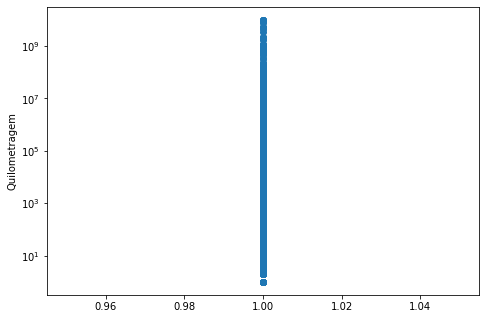

In [25]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.scatter([1]*len(df['Quilometragem']), df['Quilometragem'])
ax.set_ylabel('Quilometragem')
ax.set_yscale('log')

<AxesSubplot:ylabel='Frequency'>

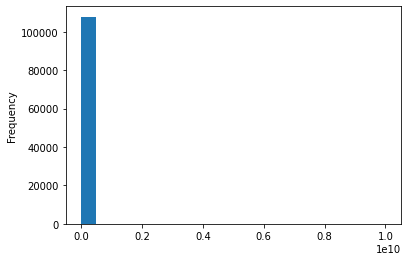

In [26]:
df['Quilometragem'].plot.hist(bins=20)

Existem outliers acima de 300000 km e também existem erros em quilometragens muito baixas como quilometragens que são abaixo de 5000. A baixa quilometragem se refere a anúncios em que a pessoa ao invés de digitar a casa dos milhares, digita apenas o número, por exemplo, para representar 130000km, a pessoa colocar apenas 130. Isso prejudicaria os modelos futuros de machine learning, portanto também serão removidos do dataset. O dataset conterá então apenas carros usados com quilometragem entre 5000km e 300000km.

In [27]:
df = df[df['Quilometragem'] >= 5000]
df = df[df['Quilometragem'] <= 300000]
df

,Modelo,Marca,Tipo de veículo,Ano,Quilometragem,Potência do motor,Combustível,Câmbio,Direção,Cor,Portas,Final de placa,CEP,Município,Bairro,price,url
0,FIAT TORO FREEDOM 1.8 16V FLEX AUT.,FIAT,Pick-up,2017,86200.0,1.8,Flex,Automático,Hidráulica,Preto,4.0,5.0,76964008.0,Cacoal,Princesa Isabel,82500.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...
1,VW - VOLKSWAGEN UP! TAKE 1.0 TOTAL FLEX 12V 5P,VW - VOLKSWAGEN,Hatch,2015,100000.0,1.0,Flex,Manual,Hidráulica,Branco,4.0,7.0,76890000.0,Jaru,NaN,32500.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...
2,GM - CHEVROLET PRISMA SED. LT 1.4 8V FLEXPOWER 4P,GM - CHEVROLET,Sedã,2017,64000.0,1.4,Flex,Manual,Elétrica,Preto,4.0,1.0,76821468.0,Porto Velho,Rio Madeira,52900.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...
3,FIAT SIENA ELX 1.0 MPI FIRE/FIRE FLEX 8V 4P,FIAT,Passeio,2007,125869.0,1.0,Flex,Manual,Mecânica,Branco,4.0,4.0,76812476.0,Porto Velho,Três Marias,14000.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...
4,FIAT IDEA ADV.EXT./ADV.EXT. LOC. 1.8 FLEX 5P,FIAT,Hatch,2013,40000.0,1.8,Flex,Automático,Hidráulica,Verde,4.0,7.0,76890000.0,Jaru,NaN,33000.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4992,FIAT UNO VIVACE CELEB. 1.0 EVO F.FLEX 8V 5P,FIAT,Hatch,2016,65000.0,1.0,Flex,Manual,Hidráulica,Cinza,4.0,3.0,66055490.0,Belém,Umarizal,34800.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...
4993,VW - VOLKSWAGEN GOL 1.0 TREND/ POWER 8V 4P,VW - VOLKSWAGEN,Hatch,2012,80000.0,1.0,Flex,Manual,Hidráulica,Prata,4.0,0.0,66120000.0,Belém,Sacramenta,26990.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...
4994,FIAT UNO WAY 1.3 FLEX 8V 5P,FIAT,Hatch,2019,32900.0,1.3,Flex,Manual,Elétrica,Prata,4.0,4.0,67140765.0,Ananindeua,Cidade Nova,45900.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...
4996,HYUNDAI HB20 COMF./C.PLUS/C.STYLE 1.0 FLEX 12V,HYUNDAI,Passeio,2018,37000.0,NaN,Flex,Manual,NaN,NaN,4.0,8.0,66123620.0,Belém,Sacramenta,49900.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...


<AxesSubplot:ylabel='Frequency'>

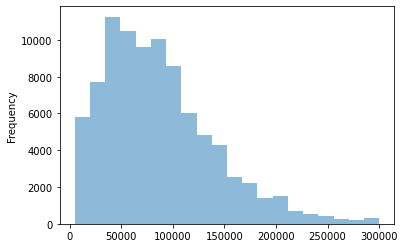

In [28]:
df['Quilometragem'].plot.hist(bins=20, alpha=0.5)

Outra modificação que podemos fazer é analisar a potência do motor que possui valores em uma faixa como mostrado abaixo. Tentaremos minimizar essa quantidade de valores que estão dentro de uma faixa modificando para o valor real da potência do motor do carro.

Para isso, podemos utilizar a coluna 'Modelo' do dataset, em muitos casos os usuários cadastram o carro indicando a potência do motor já no modelo. Portanto, podemos aplicar uma expressão regular para encontrar essa potência e caso não tenha a potência dentro da coluna 'Modelo', utilizaremos a potência fornecida na coluna 'Potência do motor'

In [29]:
item_counts = df["Potência do motor"].value_counts(normalize=True)
item_counts

1.0            0.291220
2.0 - 2.9      0.199761
1.6            0.198890
1.4            0.113693
1.8            0.092599
1.5            0.042390
3.0 - 3.9      0.037683
1.3            0.011426
4.0 ou mais    0.007094
1.2            0.001998
1.7            0.001985
1.9            0.001261
Name: Potência do motor, dtype: float64

In [30]:
import re

def find_motor_potency(row):
    potencies = re.findall('[0-9]\.[0-9]', row['Modelo'])
    
    if len(potencies) == 0:
        return row['Potência do motor']
    
    return potencies[0]

potencies = []
for i, row in tqdm(df.iterrows()):
    potency = find_motor_potency(row)
    potencies.append(potency)
    
df.insert(16, 'motor', potencies)
df

88822it [00:05, 15815.78it/s]


,Modelo,Marca,Tipo de veículo,Ano,Quilometragem,Potência do motor,Combustível,Câmbio,Direção,Cor,Portas,Final de placa,CEP,Município,Bairro,price,motor,url
0,FIAT TORO FREEDOM 1.8 16V FLEX AUT.,FIAT,Pick-up,2017,86200.0,1.8,Flex,Automático,Hidráulica,Preto,4.0,5.0,76964008.0,Cacoal,Princesa Isabel,82500.0,1.8,https://ro.olx.com.br/rondonia/autos-e-pecas/c...
1,VW - VOLKSWAGEN UP! TAKE 1.0 TOTAL FLEX 12V 5P,VW - VOLKSWAGEN,Hatch,2015,100000.0,1.0,Flex,Manual,Hidráulica,Branco,4.0,7.0,76890000.0,Jaru,NaN,32500.0,1.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...
2,GM - CHEVROLET PRISMA SED. LT 1.4 8V FLEXPOWER 4P,GM - CHEVROLET,Sedã,2017,64000.0,1.4,Flex,Manual,Elétrica,Preto,4.0,1.0,76821468.0,Porto Velho,Rio Madeira,52900.0,1.4,https://ro.olx.com.br/rondonia/autos-e-pecas/c...
3,FIAT SIENA ELX 1.0 MPI FIRE/FIRE FLEX 8V 4P,FIAT,Passeio,2007,125869.0,1.0,Flex,Manual,Mecânica,Branco,4.0,4.0,76812476.0,Porto Velho,Três Marias,14000.0,1.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...
4,FIAT IDEA ADV.EXT./ADV.EXT. LOC. 1.8 FLEX 5P,FIAT,Hatch,2013,40000.0,1.8,Flex,Automático,Hidráulica,Verde,4.0,7.0,76890000.0,Jaru,NaN,33000.0,1.8,https://ro.olx.com.br/rondonia/autos-e-pecas/c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4992,FIAT UNO VIVACE CELEB. 1.0 EVO F.FLEX 8V 5P,FIAT,Hatch,2016,65000.0,1.0,Flex,Manual,Hidráulica,Cinza,4.0,3.0,66055490.0,Belém,Umarizal,34800.0,1.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...
4993,VW - VOLKSWAGEN GOL 1.0 TREND/ POWER 8V 4P,VW - VOLKSWAGEN,Hatch,2012,80000.0,1.0,Flex,Manual,Hidráulica,Prata,4.0,0.0,66120000.0,Belém,Sacramenta,26990.0,1.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...
4994,FIAT UNO WAY 1.3 FLEX 8V 5P,FIAT,Hatch,2019,32900.0,1.3,Flex,Manual,Elétrica,Prata,4.0,4.0,67140765.0,Ananindeua,Cidade Nova,45900.0,1.3,https://pa.olx.com.br/regiao-de-belem/autos-e-...
4996,HYUNDAI HB20 COMF./C.PLUS/C.STYLE 1.0 FLEX 12V,HYUNDAI,Passeio,2018,37000.0,NaN,Flex,Manual,NaN,NaN,4.0,8.0,66123620.0,Belém,Sacramenta,49900.0,1.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...


In [31]:
item_counts = df["motor"].value_counts(normalize=True)
item_counts

1.0            0.281026
1.6            0.198661
2.0            0.131330
1.4            0.112741
1.8            0.095313
1.5            0.045352
2.8            0.022811
3.0            0.018061
2.5            0.014895
2.4            0.011364
1.3            0.010719
2.0 - 2.9      0.010262
3.2            0.009382
2.2            0.005149
2.7            0.004996
2.3            0.004597
3.5            0.002897
3.6            0.002052
1.2            0.001876
1.7            0.001701
3.0 - 3.9      0.001701
1.1            0.001525
3.9            0.001314
3.3            0.001290
4.1            0.001278
3.8            0.001032
1.9            0.000997
4.0 ou mais    0.000762
4.2            0.000727
4.0            0.000715
4.3            0.000633
6.2            0.000563
6.7            0.000504
5.0            0.000293
3.7            0.000246
4.4            0.000235
5.9            0.000141
4.5            0.000141
4.8            0.000117
3.4            0.000106
4.7            0.000106
5.7            0

In [32]:
df

,Modelo,Marca,Tipo de veículo,Ano,Quilometragem,Potência do motor,Combustível,Câmbio,Direção,Cor,Portas,Final de placa,CEP,Município,Bairro,price,motor,url
0,FIAT TORO FREEDOM 1.8 16V FLEX AUT.,FIAT,Pick-up,2017,86200.0,1.8,Flex,Automático,Hidráulica,Preto,4.0,5.0,76964008.0,Cacoal,Princesa Isabel,82500.0,1.8,https://ro.olx.com.br/rondonia/autos-e-pecas/c...
1,VW - VOLKSWAGEN UP! TAKE 1.0 TOTAL FLEX 12V 5P,VW - VOLKSWAGEN,Hatch,2015,100000.0,1.0,Flex,Manual,Hidráulica,Branco,4.0,7.0,76890000.0,Jaru,NaN,32500.0,1.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...
2,GM - CHEVROLET PRISMA SED. LT 1.4 8V FLEXPOWER 4P,GM - CHEVROLET,Sedã,2017,64000.0,1.4,Flex,Manual,Elétrica,Preto,4.0,1.0,76821468.0,Porto Velho,Rio Madeira,52900.0,1.4,https://ro.olx.com.br/rondonia/autos-e-pecas/c...
3,FIAT SIENA ELX 1.0 MPI FIRE/FIRE FLEX 8V 4P,FIAT,Passeio,2007,125869.0,1.0,Flex,Manual,Mecânica,Branco,4.0,4.0,76812476.0,Porto Velho,Três Marias,14000.0,1.0,https://ro.olx.com.br/rondonia/autos-e-pecas/c...
4,FIAT IDEA ADV.EXT./ADV.EXT. LOC. 1.8 FLEX 5P,FIAT,Hatch,2013,40000.0,1.8,Flex,Automático,Hidráulica,Verde,4.0,7.0,76890000.0,Jaru,NaN,33000.0,1.8,https://ro.olx.com.br/rondonia/autos-e-pecas/c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4992,FIAT UNO VIVACE CELEB. 1.0 EVO F.FLEX 8V 5P,FIAT,Hatch,2016,65000.0,1.0,Flex,Manual,Hidráulica,Cinza,4.0,3.0,66055490.0,Belém,Umarizal,34800.0,1.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...
4993,VW - VOLKSWAGEN GOL 1.0 TREND/ POWER 8V 4P,VW - VOLKSWAGEN,Hatch,2012,80000.0,1.0,Flex,Manual,Hidráulica,Prata,4.0,0.0,66120000.0,Belém,Sacramenta,26990.0,1.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...
4994,FIAT UNO WAY 1.3 FLEX 8V 5P,FIAT,Hatch,2019,32900.0,1.3,Flex,Manual,Elétrica,Prata,4.0,4.0,67140765.0,Ananindeua,Cidade Nova,45900.0,1.3,https://pa.olx.com.br/regiao-de-belem/autos-e-...
4996,HYUNDAI HB20 COMF./C.PLUS/C.STYLE 1.0 FLEX 12V,HYUNDAI,Passeio,2018,37000.0,NaN,Flex,Manual,NaN,NaN,4.0,8.0,66123620.0,Belém,Sacramenta,49900.0,1.0,https://pa.olx.com.br/regiao-de-belem/autos-e-...


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88822 entries, 0 to 4997
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Modelo             88822 non-null  object 
 1   Marca              88160 non-null  object 
 2   Tipo de veículo    77484 non-null  object 
 3   Ano                88822 non-null  object 
 4   Quilometragem      88822 non-null  float64
 5   Potência do motor  74569 non-null  object 
 6   Combustível        86264 non-null  object 
 7   Câmbio             86736 non-null  object 
 8   Direção            75971 non-null  object 
 9   Cor                78573 non-null  object 
 10  Portas             84726 non-null  float64
 11  Final de placa     77124 non-null  float64
 12  CEP                88822 non-null  float64
 13  Município          88821 non-null  object 
 14  Bairro             76160 non-null  object 
 15  price              88822 non-null  float64
 16  motor              8526

In [34]:
df.describe()

,Quilometragem,Portas,Final de placa,CEP,price
count,88822.000000,84726.000000,77124.000000,8.882200e+04,88822.000000
mean,86363.821823,3.802115,4.421477,6.106184e+07,58462.428790
std,53671.801664,0.597173,2.983962,2.082173e+07,46461.701234
min,5000.000000,2.000000,0.000000,1.001001e+06,5000.000000
25%,46000.000000,4.000000,2.000000,4.981250e+07,29500.000000
50%,78000.000000,4.000000,5.000000,6.503158e+07,45900.000000
75%,115000.000000,4.000000,7.000000,7.694000e+07,72900.000000
max,300000.000000,4.000000,9.000000,9.998000e+07,400000.000000


In [35]:
df.to_csv('cars_dataset.csv', index=False)